In [1]:
import numpy as np
import astropy.units as u
from astropy.constants import G
import matplotlib.pyplot as plt

# Import your Read and CenterOfMass functions
from ReadFile import Read
from CenterOfMass import CenterOfMass

class MassProfile:
    """
    A class to calculate mass profiles and rotation curves for a given galaxy at a given snapshot.
    """

    def __init__(self, galaxy, snap):
        """
        Initialize the class by reading in data from a snapshot file, and 
        computing the center of mass from disk particles.

        Parameters
        ----------
        galaxy : str
            The name of the galaxy ('MW', 'M31', or 'M33').
        snap : int
            The snapshot number, e.g., 0 for present day.
        """

        # Store galaxy name as a property
        self.gname = galaxy
        
        # Construct the filename. Example: 'MW_000.txt' if galaxy='MW' and snap=0
        ilbl = '000' + str(snap)
        ilbl = ilbl[-3:]
        self.filename = f"{galaxy}_{ilbl}.txt"
        
        # Read the data from this file
        self.time, self.total, self.data = Read(self.filename)
        
        # Store positions and masses in astropy units
        # NOTE: We multiply the mass by 1e10 Msun based on typical usage in these snapshots
        self.x = self.data['x'] * u.kpc
        self.y = self.data['y'] * u.kpc
        self.z = self.data['z'] * u.kpc
        self.m = self.data['m'] * 1e10 * u.Msun  # Msun
        
        # Compute the galaxy's COM position using DISK particles
        com_object = CenterOfMass(self.filename, 2)  # 2 = disk
        self.com_pos = com_object.COM_P(0.1)  # returns [x_COM, y_COM, z_COM] in kpc
        
        # Store G in convenient units: kpc (km/s)^2 / Msun
        self.G = G.to(u.kpc * u.km**2 / (u.s**2 * u.Msun))


    def MassEnclosed(self, ptype, radii):
        """
        Computes the mass enclosed within each radius in 'radii' (array) for particles of type 'ptype'.
        
        Parameters
        ----------
        ptype : int
            Particle type: 1 (Halo), 2 (Disk), 3 (Bulge).
        radii : np.ndarray or list of floats
            Radii in kpc at which to compute enclosed mass.
        
        Returns
        -------
        enclosed_mass : astropy.units.Quantity
            Array of enclosed masses at each radius in Msun.
        """
        # Select only particles of the requested type
        index = np.where(self.data['type'] == ptype)
        m_selected = self.m[index]  # Msun
        x_selected = self.x[index]  # kpc
        y_selected = self.y[index]  # kpc
        z_selected = self.z[index]  # kpc
        
        # Center relative to COM
        dx = x_selected - self.com_pos[0]
        dy = y_selected - self.com_pos[1]
        dz = z_selected - self.com_pos[2]
        r_part = np.sqrt(dx**2 + dy**2 + dz**2)  # distance of each particle from COM
        
        # Ensure 'radii' is an astropy quantity in kpc
        radii_kpc = radii * u.kpc
        
        # Initialize array for enclosed mass
        enclosed_mass = np.zeros(len(radii_kpc)) * u.Msun
        
        # Loop over the input radii
        for i in range(len(radii_kpc)):
            index_within = np.where(r_part < radii_kpc[i])
            enclosed_mass[i] = np.sum(m_selected[index_within])
        
        return enclosed_mass


    def MassEnclosedTotal(self, radii):
        """
        Computes the total enclosed mass (halo+disk+bulge) for each radius in 'radii'.

        Parameters
        ----------
        radii : array-like
            Radii in kpc.

        Returns
        -------
        total_mass : astropy.units.Quantity
            Array of total enclosed mass at each radius in Msun.
        """
        # Halo + Disk
        m_halo = self.MassEnclosed(1, radii)
        m_disk = self.MassEnclosed(2, radii)
        
        # Bulge (unless M33, which has no bulge)
        if self.gname == 'M33':
            m_bulge = 0 * m_halo
        else:
            m_bulge = self.MassEnclosed(3, radii)
        
        total_mass = m_halo + m_disk + m_bulge
        return total_mass


    def HernquistMass(self, r, a, Mhalo):
        """
        Computes the Hernquist 1990 mass profile: M(r) = Mhalo * (r^2 / (r+a)^2).
        
        Parameters
        ----------
        r : float or np.ndarray
            Radius (kpc)
        a : float
            Scale radius (kpc)
        Mhalo : float
            Total halo mass in Msun
        
        Returns
        -------
        M_hern : astropy.units.Quantity
            Enclosed mass at radius r in Msun.
        """
        r_kpc = r * u.kpc
        a_kpc = a * u.kpc
        Mhalo_msun = Mhalo * u.Msun
        
        frac = (r_kpc**2) / (r_kpc + a_kpc)**2
        M_hern = Mhalo_msun * frac
        return M_hern


    def CircularVelocity(self, ptype, radii):
        """
        Computes the circular velocity for the given component at each radius in 'radii'.
        
        Vc(r) = sqrt(G * M_enclosed(r) / r)
        
        Parameters
        ----------
        ptype : int
            Particle type (1=Halo, 2=Disk, 3=Bulge).
        radii : np.ndarray
            Radii in kpc.
        
        Returns
        -------
        V_circ : astropy.units.Quantity
            Circular velocity in km/s (rounded to 2 decimals).
        """
        # Enclosed mass
        Menc = self.MassEnclosed(ptype, radii)  # Msun
        r_kpc = radii * u.kpc
        
        V_circ = np.sqrt(self.G * Menc / r_kpc)
        return np.round(V_circ, 2)


    def CircularVelocityTotal(self, radii):
        """
        Computes the total circular velocity (halo + disk + bulge) at each radius in 'radii'.
        
        V_circ_total(r) = sqrt(G * [M_halo + M_disk + M_bulge] / r)
        
        Parameters
        ----------
        radii : array-like
            Radii in kpc.
        
        Returns
        -------
        V_circ_total : astropy.units.Quantity
            Total circular velocity in km/s (rounded to 2 decimals).
        """
        Mtot = self.MassEnclosedTotal(radii)  # Msun
        r_kpc = radii * u.kpc
        
        V_circ = np.sqrt(self.G * Mtot / r_kpc)
        return np.round(V_circ, 2)


    def HernquistVCirc(self, r, a, Mhalo):
        """
        Computes the circular velocity for a Hernquist halo:
        M(r) = Mhalo * (r^2 / (r+a)^2).
        V_circ(r) = sqrt(G * M(r) / r).
        
        Parameters
        ----------
        r : float or array-like
            Radius in kpc.
        a : float
            Scale radius in kpc.
        Mhalo : float
            Halo mass in Msun.
        
        Returns
        -------
        V_hern : astropy.units.Quantity
            Hernquist circular velocity in km/s (rounded to 2 decimals).
        """
        r_kpc = r * u.kpc
        a_kpc = a * u.kpc
        Mhalo_msun = Mhalo * u.Msun
        
        # M(r) for Hernquist
        M_hern = Mhalo_msun * (r_kpc**2 / (r_kpc + a_kpc)**2)
        
        V_hern = np.sqrt(self.G * M_hern / r_kpc)
        return np.round(V_hern, 2)


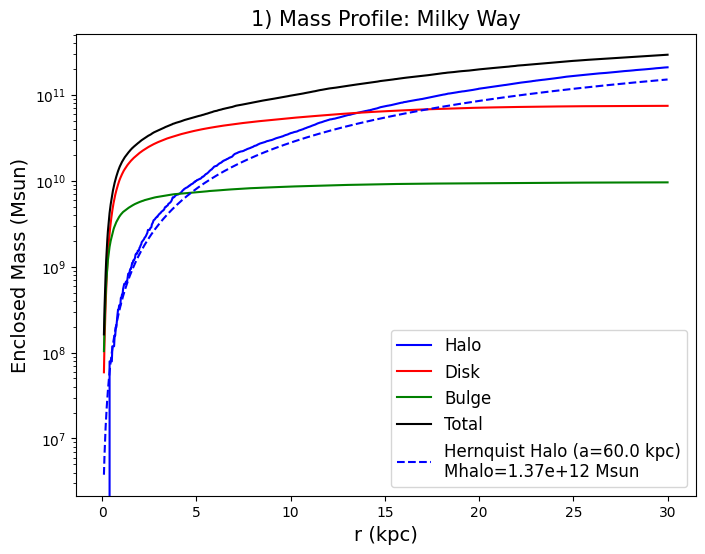

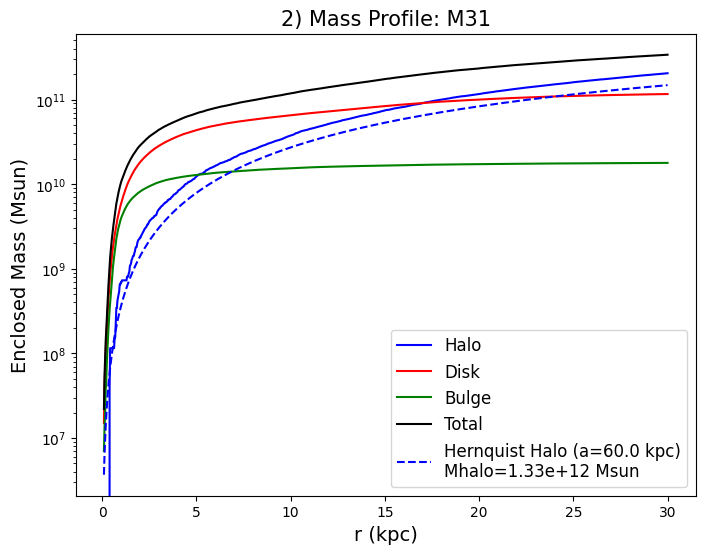

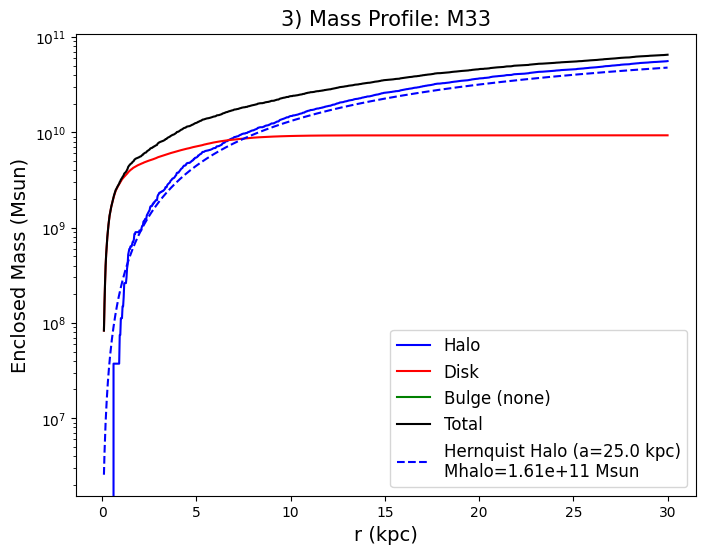

In [6]:
# Create MassProfile objects for each galaxy at Snapshot 0
MW = MassProfile("MW", 0)
M31 = MassProfile("M31", 0)
M33 = MassProfile("M33", 0)

# We often plot from 0.1 to 30 kpc
r_plot = np.linspace(0.1, 30, 1000)

##################################
# 1) Milky Way Mass Profile
##################################
# Enclosed mass of each component up to 30 kpc
M_halo_MW_30 = MW.MassEnclosed(1, r_plot)
M_disk_MW_30 = MW.MassEnclosed(2, r_plot)
M_bulge_MW_30 = MW.MassEnclosed(3, r_plot)
M_total_MW_30 = MW.MassEnclosedTotal(r_plot)

# Use a bigger radius for the total halo mass
big_radius = 300.0  # kpc
# Compute halo mass at that radius:
M_halo_MW_300 = MW.MassEnclosed(1, np.array([big_radius]))
MW_halo_mass_total = M_halo_MW_300[0].value  # a float in Msun

# Choose a Hernquist scale radius (trial & error):
a_guess_MW = 60.0  # kpc
# Get the theoretical Hernquist halo mass at 0.1-30 kpc
M_hern_MW_30 = MW.HernquistMass(r_plot, a_guess_MW, MW_halo_mass_total)

# Plot for MW
plt.figure(figsize=(8,6))
plt.semilogy(r_plot, M_halo_MW_30, color='b', label='Halo')
plt.semilogy(r_plot, M_disk_MW_30, color='r', label='Disk')
plt.semilogy(r_plot, M_bulge_MW_30, color='g', label='Bulge')
plt.semilogy(r_plot, M_total_MW_30, color='k', label='Total')

# Overplot Hernquist
plt.semilogy(r_plot, M_hern_MW_30, 'b--',
             label=f'Hernquist Halo (a={a_guess_MW} kpc)\nMhalo={MW_halo_mass_total:.2e} Msun')

plt.title('1) Mass Profile: Milky Way', fontsize=15)
plt.xlabel('r (kpc)', fontsize=14)
plt.ylabel('Enclosed Mass (Msun)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.savefig("1 Mass Profile Milky Way.png", dpi=300, bbox_inches="tight")
plt.show()


##################################
# 2) M31 Mass Profile
##################################
M_halo_M31_30 = M31.MassEnclosed(1, r_plot)
M_disk_M31_30 = M31.MassEnclosed(2, r_plot)
M_bulge_M31_30 = M31.MassEnclosed(3, r_plot)
M_total_M31_30 = M31.MassEnclosedTotal(r_plot)

# Use big radius for total halo mass
M_halo_M31_300 = M31.MassEnclosed(1, np.array([big_radius]))
M31_halo_mass_total = M_halo_M31_300[0].value

a_guess_M31 = 60.0  # kpc
M_hern_M31_30 = M31.HernquistMass(r_plot, a_guess_M31, M31_halo_mass_total)

plt.figure(figsize=(8,6))
plt.semilogy(r_plot, M_halo_M31_30, color='b', label='Halo')
plt.semilogy(r_plot, M_disk_M31_30, color='r', label='Disk')
plt.semilogy(r_plot, M_bulge_M31_30, color='g', label='Bulge')
plt.semilogy(r_plot, M_total_M31_30, color='k', label='Total')

plt.semilogy(r_plot, M_hern_M31_30, 'b--',
             label=f'Hernquist Halo (a={a_guess_M31} kpc)\nMhalo={M31_halo_mass_total:.2e} Msun')

plt.title('2) Mass Profile: M31', fontsize=15)
plt.xlabel('r (kpc)', fontsize=14)
plt.ylabel('Enclosed Mass (Msun)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.savefig("2 Mass Profile M31.png", dpi=300, bbox_inches="tight")
plt.show()


##################################
# 3) M33 Mass Profile
##################################
M_halo_M33_30 = M33.MassEnclosed(1, r_plot)
M_disk_M33_30 = M33.MassEnclosed(2, r_plot)
# M33 has no bulge, so bulge mass is zero
M_bulge_M33_30 = 0.0 * M_halo_M33_30
M_total_M33_30 = M33.MassEnclosedTotal(r_plot)

# Use big radius for total halo mass
M_halo_M33_300 = M33.MassEnclosed(1, np.array([big_radius]))
M33_halo_mass_total = M_halo_M33_300[0].value

a_guess_M33 = 25.0  # kpc
M_hern_M33_30 = M33.HernquistMass(r_plot, a_guess_M33, M33_halo_mass_total)

plt.figure(figsize=(8,6))
plt.semilogy(r_plot, M_halo_M33_30, color='b', label='Halo')
plt.semilogy(r_plot, M_disk_M33_30, color='r', label='Disk')
plt.semilogy(r_plot, M_bulge_M33_30, color='g', label='Bulge (none)')
plt.semilogy(r_plot, M_total_M33_30, color='k', label='Total')

plt.semilogy(r_plot, M_hern_M33_30, 'b--',
             label=f'Hernquist Halo (a={a_guess_M33} kpc)\nMhalo={M33_halo_mass_total:.2e} Msun')

plt.title('3) Mass Profile: M33', fontsize=15)
plt.xlabel('r (kpc)', fontsize=14)
plt.ylabel('Enclosed Mass (Msun)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.savefig("3 Mass Profile M33.png", dpi=300, bbox_inches="tight")
plt.show()


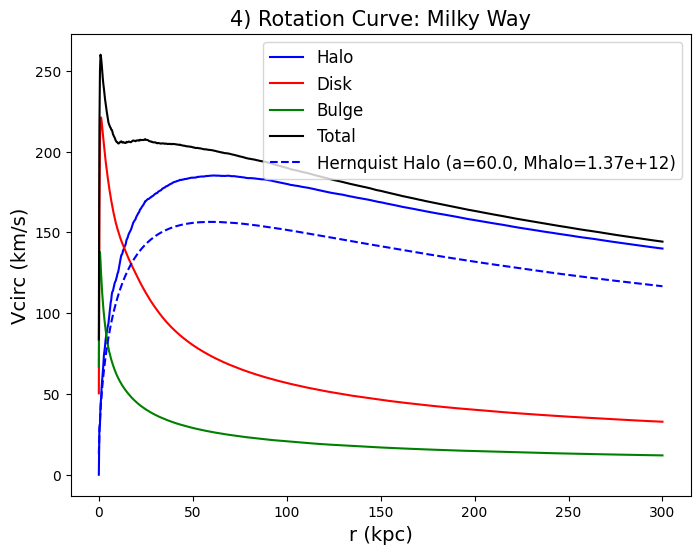

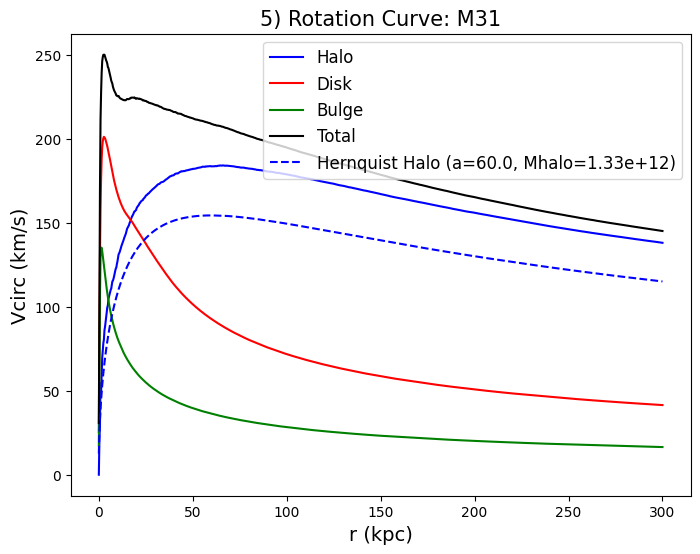

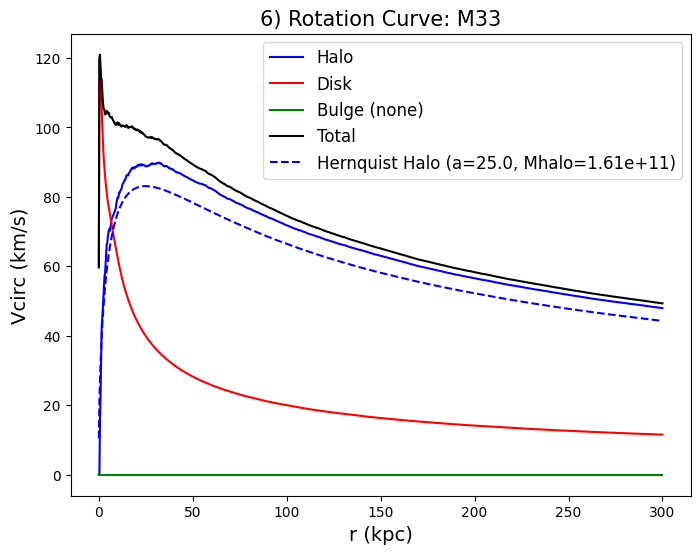

In [5]:
# Define radii array for rotation curves (0.1 to 300 kpc)
r_circ = np.linspace(0.1, 300, 1000)

##################################
# 4) Milky Way Rotation Curve
##################################
Vhalo_MW = MW.CircularVelocity(1, r_circ)
Vdisk_MW = MW.CircularVelocity(2, r_circ)
Vbulge_MW = MW.CircularVelocity(3, r_circ)
Vtotal_MW = MW.CircularVelocityTotal(r_circ)

# Reuse the big-radius total halo mass from Cell 2: MW_halo_mass_total
MW_Vhern = MW.HernquistVCirc(r_circ, a_guess_MW, MW_halo_mass_total)

plt.figure(figsize=(8,6))
plt.plot(r_circ, Vhalo_MW, 'b', label='Halo')
plt.plot(r_circ, Vdisk_MW, 'r', label='Disk')
plt.plot(r_circ, Vbulge_MW, 'g', label='Bulge')
plt.plot(r_circ, Vtotal_MW, 'k', label='Total')

# Overplot the Hernquist halo velocity
plt.plot(r_circ, MW_Vhern, 'b--',
         label=f'Hernquist Halo (a={a_guess_MW}, Mhalo={MW_halo_mass_total:.2e})')

plt.title('4) Rotation Curve: Milky Way', fontsize=15)
plt.xlabel('r (kpc)', fontsize=14)
plt.ylabel('Vcirc (km/s)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.savefig("4 Rotation Curve MilkyWay.png", dpi=300, bbox_inches="tight")
plt.show()


##################################
# 5) M31 Rotation Curve
##################################
Vhalo_M31 = M31.CircularVelocity(1, r_circ)
Vdisk_M31 = M31.CircularVelocity(2, r_circ)
Vbulge_M31 = M31.CircularVelocity(3, r_circ)
Vtotal_M31 = M31.CircularVelocityTotal(r_circ)

M31_Vhern = M31.HernquistVCirc(r_circ, a_guess_M31, M31_halo_mass_total)

plt.figure(figsize=(8,6))
plt.plot(r_circ, Vhalo_M31, 'b', label='Halo')
plt.plot(r_circ, Vdisk_M31, 'r', label='Disk')
plt.plot(r_circ, Vbulge_M31, 'g', label='Bulge')
plt.plot(r_circ, Vtotal_M31, 'k', label='Total')

plt.plot(r_circ, M31_Vhern, 'b--',
         label=f'Hernquist Halo (a={a_guess_M31}, Mhalo={M31_halo_mass_total:.2e})')

plt.title('5) Rotation Curve: M31', fontsize=15)
plt.xlabel('r (kpc)', fontsize=14)
plt.ylabel('Vcirc (km/s)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.savefig("5 Rotation Curve M31.png", dpi=300, bbox_inches="tight")
plt.show()


##################################
# 6) M33 Rotation Curve
##################################
Vhalo_M33 = M33.CircularVelocity(1, r_circ)
Vdisk_M33 = M33.CircularVelocity(2, r_circ)
Vbulge_M33 = 0.0 * Vhalo_M33  # M33 has no bulge
Vtotal_M33 = M33.CircularVelocityTotal(r_circ)

M33_Vhern = M33.HernquistVCirc(r_circ, a_guess_M33, M33_halo_mass_total)

plt.figure(figsize=(8,6))
plt.plot(r_circ, Vhalo_M33, 'b', label='Halo')
plt.plot(r_circ, Vdisk_M33, 'r', label='Disk')
plt.plot(r_circ, Vbulge_M33, 'g', label='Bulge (none)')
plt.plot(r_circ, Vtotal_M33, 'k', label='Total')

plt.plot(r_circ, M33_Vhern, 'b--',
         label=f'Hernquist Halo (a={a_guess_M33}, Mhalo={M33_halo_mass_total:.2e})')

plt.title('6) Rotation Curve: M33', fontsize=15)
plt.xlabel('r (kpc)', fontsize=14)
plt.ylabel('Vcirc (km/s)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.savefig("6 Rotation Curve M33.png", dpi=300, bbox_inches="tight")
plt.show()
